In [1]:
import pydot
import graphviz
import os 
import numpy as np 
import cv2
import random

from PIL import Image
from numpy import zeros, ones
from numpy.random import randn, randint 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tqdm import tqdm
from numpy import linspace
from numpy import asarray
from numpy.random import randn

In [2]:
def Discriminator(in_shape=(128, 128, 3)):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

discriminator = Discriminator()
print(discriminator.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       1

In [3]:
def Generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (8, 8), activation='tanh', padding='same'))
    return model

generator = Generator(100)
print(generator.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [4]:
def GAN(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

gan = GAN(generator, discriminator)
print(gan.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       1901059   
                                                                 
 sequential (Sequential)     (None, 1)                 602113    
                                                                 
Total params: 2,503,172
Trainable params: 1,901,059
Non-trainable params: 602,113
_________________________________________________________________
None


In [5]:
def generate_real_samples(dataset, n_samples):
    idx = randint(0, dataset.shape[0], n_samples)
    X = dataset[idx]
    y = ones((n_samples, 1))
    return X, y

def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

def save_plot(examples, epoch, n=10):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.axis('off')
        plt.imshow(examples[i])
    filename = './desiredGAN_Generate/images/generated_plot_128x128_e%03d.png' % (epoch + 1)
    plt.savefig(filename)
    plt.close()
    
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
    
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real * 100, acc_fake * 100))
    save_plot(X_fake, epoch)
    modelpath = './desiredGAN_Generate/models/generator_model_128x128_%03d.h5' % (epoch + 1)
    g_model.save(modelpath)

In [6]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        for j in tqdm(range(batch_per_epoch), total=batch_per_epoch):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('Epoch>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' % (i + 1, j + 1, batch_per_epoch, d_loss1, d_loss2, g_loss))
            
        if (i + 1) % 1 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [7]:
n = 2000
SIZE = 128
all_img_list = os.listdir('./UTKFace/')
dataset_list = random.sample(all_img_list, n)

dataset = []
print('Processing Images')
for img in tqdm(dataset_list, total=len(dataset_list)):
    temp_img = cv2.imread('./UTKFace/' + img)
    if temp_img is None:
        continue
    else:
        temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
        temp_img = Image.fromarray(temp_img)
        temp_img = temp_img.resize((SIZE, SIZE))
        dataset.append(np.array(temp_img))
print('Done Successfully!!!')
    
dataset = np.array(dataset)
dataset = dataset.astype('float32')
dataset = (dataset - 127.5) / 127.5

latent_dim = 100
discriminator = Discriminator()
generator = Generator(latent_dim)
gan = GAN(generator, discriminator)
# train(generator, discriminator, gan, dataset, latent_dim, n_epochs=5)

Processing Images


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 523.67it/s]


Done Successfully!!!


In [8]:
def plot_generated1(examples, n):
    plt.figure(figsize=(8, 8))
    for i in range(n * n):
        plt.subplot(n ,n, i + 1)
        plt.axis('off')
        plt.imshow(examples[i, :, :])
    plt.show()

def plot_generated2(examples, n):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.axis('off')
        plt.imshow(examples[i, :, :])
    plt.show()
    
def plot_generated3(examples, n):
    plt.figure(figsize=(16, 16))
    for i in range(n * n):
        plt.subplot(n ,n, i + 1)
        plt.axis('off')
        plt.imshow(examples[i, :, :])
    plt.show()

def interpolate_points(p1, p2, n_steps=10):
    ratios = linspace(0, 1, n_steps)
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)

model = load_model('./desiredGAN_Generate/kaggle_pretrained_model/generator_model_128x128_100.h5', compile=False)

1/1 [==============================] - 1s 1s/step


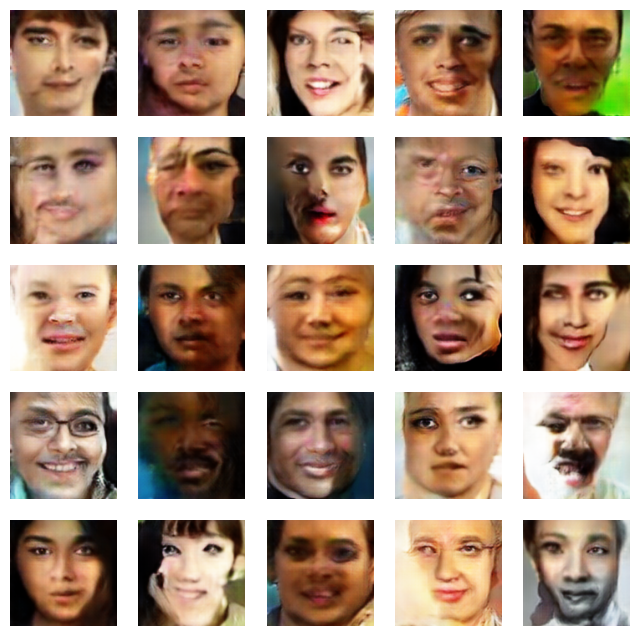

In [9]:
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
X = (X + 1.0) / 2.0
plot_generated1(X, 5)

1/1 [==============================] - 0s 447ms/step


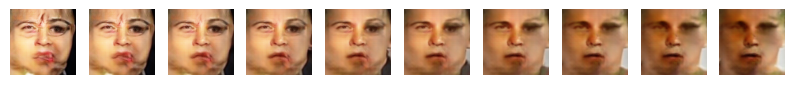

In [10]:
pts = generate_latent_points(100, 2)
interpolated = interpolate_points(pts[0], pts[1])
X = model.predict(interpolated)
X = (X + 1.0) / 2.0
plot_generated2(X, len(interpolated))

4/4 [==============================] - 4s 935ms/step


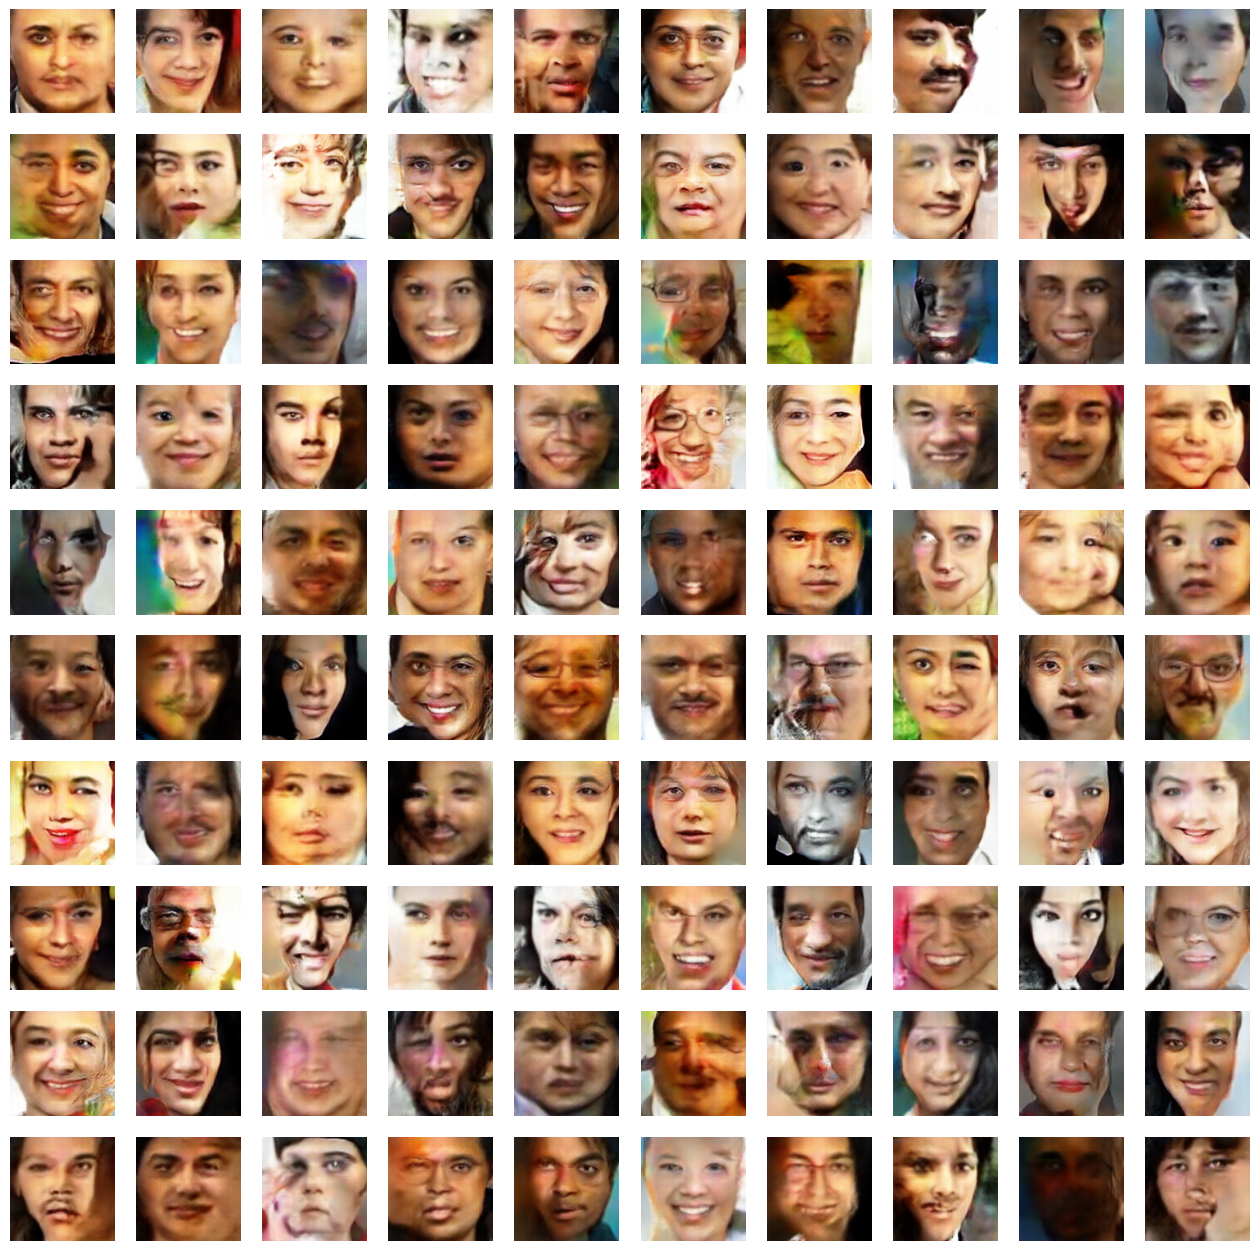

In [11]:
latent_points = generate_latent_points(100, 100)
X = model.predict(latent_points)
X = (X + 1.0) / 2.0
plot_generated3(X, 10)